In [1]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

from etmtm import ETMTM, taper

In [2]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'IU'
station = 'RSSD'

inv = client.get_stations(network=network, station=station, level='response')

sta = inv[0][0]
sta

Station RSSD (Black Hills, South Dakota, USA)
	Station Code: RSSD
	Channel Count: 72/72 (Selected/Total)
	1999-09-24T00:00:00.000000Z - 2009-09-08T20:00:00.000000Z
	Access: open 
	Latitude: 44.12, Longitude: -104.04, Elevation: 2090.0 m
	Available Channels:
		RSSD..BC0, RSSD..BC1, RSSD.00.BHZ (3x), RSSD.00.BH1 (4x), 
		RSSD.00.BH2 (4x), RSSD.00.LHZ (3x), RSSD.00.LH1 (4x), 
		RSSD.00.LH2 (4x), RSSD.00.UHZ (2x), RSSD.00.UH1 (3x), 
		RSSD.00.UH2 (3x), RSSD.00.VE1, RSSD.00.VHZ (3x), RSSD.00.VH1 (4x), 
		RSSD.00.VH2 (4x), RSSD.00.VK1, RSSD.10.BHZ, RSSD.10.BHN, RSSD.10.BHE
		RSSD.10.HHZ, RSSD.10.HHN, RSSD.10.HHE, RSSD.10.LHZ, RSSD.10.LHN, 
		RSSD.10.LHE, RSSD.20.HLZ, RSSD.20.HLN, RSSD.20.HLE, RSSD.20.HNZ (2x)
		RSSD.20.HNN (2x), RSSD.20.HNE (2x), RSSD.20.LLZ, RSSD.20.LLN, 
		RSSD.20.LLE, RSSD.20.LNZ (2x), RSSD.20.LNN (2x), RSSD.20.LNE (2x)

In [3]:
import wget

!rm *.ndk

years = range(6,18)

months  = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

for year in years:
    for month in months:
        url='http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/20%02d/%s%02d.ndk' % (year, month, year)
        print(url)
        wget.download( url )

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jan06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/feb06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/mar06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/apr06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/may06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jun06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jul06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/aug06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/sep06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/oct06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/nov06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/dec06.ndk
http

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/may14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jun14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jul14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/aug14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/sep14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/oct14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/nov14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/dec14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/jan15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/feb15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/mar15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/apr15.ndk
http

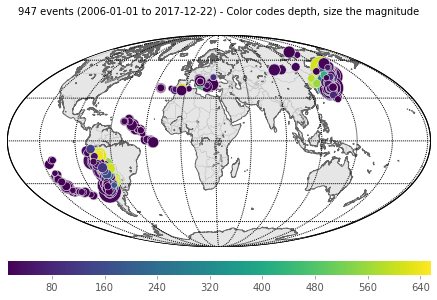

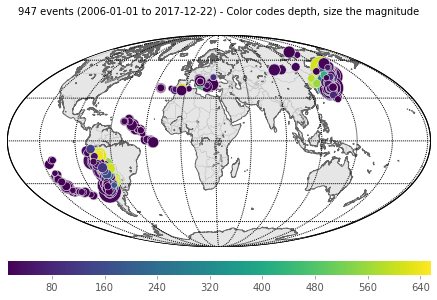

In [4]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.core.event.Catalog()

for year in years:
    for month in months:
        tmp = obspy.read_events('%s%02d.ndk' % (month, year))
        cat = cat + tmp.filter('magnitude >= 5.5')
    
    
cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
cat2.plot()
    

In [5]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.80

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'10','LH?',t1,t2,attach_response=True)
            except:
                print('  get_waveforms failed.')
                break

            pre_filt = (0.005, 0.01, 5.0, 10.0)
            stis.remove_response(output='VEL', pre_filt=pre_filt)
            #


        print(stis)
        if len(stis) > 3:
            break

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        stis.rotate('->ZNE',inventory=inv)
        #stis.rotate('NE->RT', back_azimuth = baz)
        stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
        stis.detrend()

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            
            stis2=stis.copy().trim(t1+tshift,t2+tshift)
            
            try:
                dt = stis2[0].stats.delta
            except IndexError as e:
                print(e)
                break
                
            assert 'L' in stis2[0].stats.channel
            assert 'Q' in stis2[1].stats.channel
            #assert 'T' in stis2[2].stats.channel
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

            smax  = max(abs(P))
            nmax1 = max(abs(N1))
            nmax2 = max(abs(N2))
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            _, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        

Working on     1 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
    31.5    140.1   12.0     44.1   -104.0    72.00    37.00    96.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
Working on     2 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-01-10T01:09:37.610451Z - 2006-01-10T01:39:36.610451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-01-10T01:09:37.610451Z - 2006-01-10T01:39:36.610451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
Working on    14 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
    56.2    164.2   24.0     44.1   -104.0   283.00    81.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-12T01:23:30.600000Z - 2006-04-12T01:25:10.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-12T01:23:30.600000Z - 2006-04-12T01:25:10.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-12T01:23:30.60000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
    54.5    164.0   25.6     44.1   -104.0   327.00    80.00  -178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
Working on    26 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-05-22T13:08:05.549062Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
Working on    38 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
   -24.4    -67.2  185.8     44.1   -104.0   194.00    36.00   -48.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-08-25T01:04:58.800000Z - 2006-08-25T01:06:38.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-08-25T01:04:58.800000Z - 2006-08-25T01:06:38.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-08-25T01:04:58.80000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-10-01T09:06:09.535899Z - 2006-10-01T09:36:08.535899Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-01T09:06:09.535912Z - 2006-10-01T09:36:08.535912Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-01T09:06:09.535861Z - 2006-10-01T09:36:08.535861Z | 1.0 Hz, 1800 samples
    46.4    153.6   12.8     44.1   -104.0   224.00    29.00   100.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
Working on    50 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-10-07T08:21:01.536157Z - 2006-10-07T08:51:00.536157Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-07T08:21:01.536160Z - 2006-10-07T08:51:00.536160Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-07T08:21:01.536157Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
Working on    61 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-07T13:25:41.061019Z - 2006-11-07T13:55:40.061019Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-07T13:25:41.061018Z - 2006-11-07T13:55:40.061018Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-07T13:25:41.061015Z - 2006-11-07T13:55:40.061015Z | 1.0 Hz, 1800 samples
   -21.9    -68.7  139.6     44.1   -104.0   282.00    13.00    13.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-07T13:45:25.000000Z - 2006-11-07T13:47:04.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-07T13:45:25.000000Z - 2006-11-07T13:47:04.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-07T13:45:25.00000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-22T11:15:13.061053Z - 2006-11-22T11:45:12.061053Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-22T11:15:13.061056Z - 2006-11-22T11:45:12.061056Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-22T11:15:13.061057Z - 2006-11-22T11:45:12.061057Z | 1.0 Hz, 1800 samples
    44.1    146.8  105.5     44.1   -104.0    29.00    43.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
Working on    73 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-23T20:04:52.061037Z - 2006-11-23T20:34:51.061037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-23T20:04:52.061037Z - 2006-11-23T20:34:51.061037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-23T20:04:52.061037Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
Working on    84 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
    34.9    138.8  169.8     44.1   -104.0    80.00    34.00   177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-01-15T18:39:21.000000Z - 2007-01-15T18:41:00.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-01-15T18:39:21.000000Z - 2007-01-15T18:41:00.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-01-15T18:39:21.00000

  get_waveforms failed.
Working on    96 of   947
  get_waveforms failed.
Working on    97 of   947
  get_waveforms failed.
Working on    98 of   947
  get_waveforms failed.
Working on    99 of   947
  get_waveforms failed.
Working on   100 of   947
  get_waveforms failed.
Working on   101 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-04-04T21:40:24.110561Z - 2007-04-04T22:10:23.110561Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-04-04T21:40:24.110566Z - 2007-04-04T22:10:23.110566Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-04-04T21:40:24.110558Z - 2007-04-04T22:10:23.110558Z | 1.0 Hz, 1800 samples
    30.9    141.8   18.3     44.1   -104.0   192.00    26.00   113.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
   -15.8    -75.2   15.0     44.1   -104.0   318.00    16.00    64.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
Working on   113 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-06-28T19:25:23.398043Z - 2007-06-28T19:55:22.398043Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-06-28T19:25:23.398041Z - 2007-06-28T19:55:22.398041Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-06-28T19:25:23.398051Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
Working on   125 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-02T05:22:21.738252Z - 2007-08-02T05:52:20.738252Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-02T05:22:21.738322Z - 2007-08-02T05:52:20.738322Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-02T05:22:21.738609Z - 2007-08-02T05:52:20.738609Z | 1.0 Hz, 1800 samples
    46.8    141.7   13.4     44.1   -104.0     2.00    39.00    80.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-02T05:42:21.900000Z - 2007-08-02T05:44:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-02T05:42:21.900000Z - 2007-08-02T05:44:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-02T05:42:21.90000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-28T01:16:08.435661Z - 2007-08-28T01:46:07.435661Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-28T01:16:08.435660Z - 2007-08-28T01:46:07.435660Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-28T01:16:08.435663Z - 2007-08-28T01:46:07.435663Z | 1.0 Hz, 1800 samples
    49.5    154.8  117.6     44.1   -104.0    59.00     4.00   114.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
Working on   137 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-29T16:18:14.435451Z - 2007-08-29T16:48:13.435451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-29T16:18:14.435451Z - 2007-08-29T16:48:13.435451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-29T16:18:14.435451Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
Working on   149 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-11-18T12:15:43.110931Z - 2007-11-18T12:45:42.110931Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-11-18T12:15:43.110945Z - 2007-11-18T12:45:42.110945Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-11-18T12:15:43.110950Z - 2007-11-18T12:45:42.110950Z | 1.0 Hz, 1800 samples
   -23.0    -70.9   19.8     44.1   -104.0   328.00    22.00    68.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-18T12:35:52.600000Z - 2007-11-18T12:37:32.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-18T12:35:52.600000Z - 2007-11-18T12:37:32.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-11-18T12:35:52.60000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-12-16T08:09:21.823164Z - 2007-12-16T08:39:20.823164Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-12-16T08:09:21.823170Z - 2007-12-16T08:39:20.823170Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-12-16T08:09:21.823162Z - 2007-12-16T08:39:20.823162Z | 1.0 Hz, 1800 samples
   -23.0    -70.4   30.6     44.1   -104.0   246.00     6.00   159.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
Working on   161 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-12-25T14:04:38.410843Z - 2007-12-25T14:34:37.410843Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-12-25T14:04:38.410842Z - 2007-12-25T14:34:37.410842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-12-25T14:04:38.410842Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
Working on   172 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-03-03T09:31:10.947878Z - 2008-03-03T10:01:09.947878Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-03-03T09:31:10.947873Z - 2008-03-03T10:01:09.947873Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-03-03T09:31:10.947875Z - 2008-03-03T10:01:09.947875Z | 1.0 Hz, 1800 samples
    46.3    153.4   13.6     44.1   -104.0   230.00    29.00   105.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-03-03T09:50:06.700000Z - 2008-03-03T09:51:46.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-03-03T09:50:06.700000Z - 2008-03-03T09:51:46.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-03-03T09:50:06.70000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
    42.5    132.0  530.3     44.1   -104.0   279.00    63.00   -19.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
Working on   184 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-05-23T19:35:41.647599Z - 2008-05-23T20:05:40.647599Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-05-23T19:35:41.647596Z - 2008-05-23T20:05:40.647596Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-05-23T19:35:41.647576Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
Working on   195 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
    45.1    137.4  328.3     44.1   -104.0   168.00    38.00    -9.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-06-29T21:12:41.700000Z - 2008-06-29T21:14:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-06-29T21:12:41.700000Z - 2008-06-29T21:14:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-06-29T21:12:41.70000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-08-16T04:01:12.497713Z - 2008-08-16T04:31:11.497713Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-08-16T04:01:12.497708Z - 2008-08-16T04:31:11.497708Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-08-16T04:01:12.497680Z - 2008-08-16T04:31:11.497680Z | 1.0 Hz, 1800 samples
    52.2     98.3   28.2     44.1   -104.0    14.00    81.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
Working on   207 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-08-19T10:58:07.498341Z - 2008-08-19T11:28:06.498341Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-08-19T10:58:07.498341Z - 2008-08-19T11:28:06.498341Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-08-19T10:58:07.498341Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
Working on   218 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-10-03T05:26:27.098330Z - 2008-10-03T05:56:26.098330Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-10-03T05:26:27.098327Z - 2008-10-03T05:56:26.098327Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-10-03T05:26:27.098331Z - 2008-10-03T05:56:26.098331Z | 1.0 Hz, 1800 samples
     7.8    -37.0   16.7     44.1   -104.0     1.00    79.00     0.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-10-03T05:45:37.00000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-12-18T21:19:33.948328Z - 2008-12-18T21:49:32.948328Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-12-18T21:19:33.948327Z - 2008-12-18T21:49:32.948327Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-12-18T21:19:33.948323Z - 2008-12-18T21:49:32.948323Z | 1.0 Hz, 1800 samples
   -32.6    -72.1   22.5     44.1   -104.0   360.00    19.00    94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
Working on   230 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-12-18T21:50:34.948334Z - 2008-12-18T22:20:33.948334Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-12-18T21:50:34.948334Z - 2008-12-18T22:20:33.948334Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-12-18T21:50:34.948331Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
Working on   241 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
    40.3    142.6   48.0     44.1   -104.0   180.00    26.00    68.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-02-15T09:45:15.700000Z - 2009-02-15T09:46:55.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-02-15T09:45:15.700000Z - 2009-02-15T09:46:55.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-02-15T09:45:15.70000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
    41.7    143.7   31.6     44.1   -104.0   221.00    16.00    99.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
Working on   253 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-06-05T13:39:15.100100Z - 2009-06-05T14:09:14.100100Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-06-05T13:39:15.100096Z - 2009-06-05T14:09:14.100096Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-06-05T13:39:15.100096Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
Working on   264 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
   -29.2   -112.4   12.7     44.1   -104.0   115.00    86.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-09-17T23:41:58.600000Z - 2009-09-17T23:43:38.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-09-17T23:41:58.600000Z - 2009-09-17T23:43:38.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-09-17T23:41:58.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
    36.5     -9.9   47.6     44.1   -104.0   316.00    35.00  -170.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
Working on   276 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-12-24T00:23:37.069538Z - 2009-12-24T00:53:36.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-12-24T00:23:37.069538Z - 2009-12-24T00:53:36.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-12-24T00:23:37.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
Working on   287 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
   -36.0    -73.2   23.2     44.1   -104.0    19.00    18.00   116.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-27T06:57:22.500000Z - 2010-02-27T06:59:02.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-27T06:57:22.500000Z - 2010-02-27T06:59:02.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-27T06:57:22.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
    44.1    147.8   52.2     44.1   -104.0   230.00    44.00    17.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
Working on   299 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-07T07:05:33.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
Working on   310 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
    52.1    142.1   12.0     44.1   -104.0   349.00    40.00    93.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-16T10:03:32.900000Z - 2010-03-16T10:05:12.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-16T10:03:32.900000Z - 2010-03-16T10:05:12.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-16T10:03:32.90000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
   -34.5    -72.2   15.3     44.1   -104.0    26.00    25.00   -36.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
Working on   322 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-05-05T09:38:32.069538Z - 2010-05-05T10:08:31.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-05-05T09:38:32.069538Z - 2010-05-05T10:08:31.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-05-05T09:38:32.069539Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
Working on   333 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-07-12T00:11:27.069538Z - 2010-07-12T00:41:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-07-12T00:11:27.069538Z - 2010-07-12T00:41:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-07-12T00:11:27.069539Z - 2010-07-12T00:41:26.069539Z | 1.0 Hz, 1800 samples
   -22.4    -68.6  134.7     44.1   -104.0   167.00    40.00   -73.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-07-12T00:31:17.000000Z - 2010-07-12T00:32:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-07-12T00:31:17.000000Z - 2010-07-12T00:32:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-07-12T00:31:17.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-09-30T00:26:20.069539Z - 2010-09-30T00:56:19.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-09-30T00:26:20.069538Z - 2010-09-30T00:56:19.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-09-30T00:26:20.069538Z - 2010-09-30T00:56:19.069538Z | 1.0 Hz, 1800 samples
   -36.5    -74.1   12.4     44.1   -104.0     9.00    17.00    98.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
Working on   345 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-10-14T13:58:59.069538Z - 2010-10-14T14:28:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-10-14T13:58:59.069538Z - 2010-10-14T14:28:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-10-14T13:58:59.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
Working on   356 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-01-10T06:02:54.069539Z - 2011-01-10T06:32:53.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-01-10T06:02:54.069538Z - 2011-01-10T06:32:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-01-10T06:02:54.069538Z - 2011-01-10T06:32:53.069538Z | 1.0 Hz, 1800 samples
   -35.8    -73.6   12.1     44.1   -104.0    22.00    14.00   105.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-01-10T06:25:01.800000Z - 2011-01-10T06:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-01-10T06:25:01.800000Z - 2011-01-10T06:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-01-10T06:25:01.80000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-09T21:24:09.069539Z - 2011-03-09T21:54:08.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-09T21:24:09.069538Z - 2011-03-09T21:54:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-09T21:24:09.069538Z - 2011-03-09T21:54:08.069538Z | 1.0 Hz, 1800 samples
    38.3    142.8   22.6     44.1   -104.0   191.00    19.00    80.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
Working on   368 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-10T08:08:23.069538Z - 2011-03-10T08:38:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-10T08:08:23.069538Z - 2011-03-10T08:38:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-10T08:08:23.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
Working on   379 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
    36.0    141.5   35.0     44.1   -104.0   270.00    43.00   -89.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-12T03:33:24.700000Z - 2011-03-12T03:35:04.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-12T03:33:24.700000Z - 2011-03-12T03:35:04.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-12T03:33:24.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
    36.4    142.2   12.0     44.1   -104.0    57.00    37.00    75.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
Working on   391 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-13T07:56:47.069538Z - 2011-03-13T08:26:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-13T07:56:47.069538Z - 2011-03-13T08:26:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-13T07:56:47.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-15T15:44:38.500000Z - 2011-03-15T15:46:18.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-15T15:44:38.500000Z - 2011-03-15T15:46:18.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-15T15:44:38.500000Z - 2011-03-15T15:46:18.400000Z | 10.0 Hz, 1000 samples
Working on   402 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-15T20:30:02.069538Z - 2011-03-15T21:00:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-15T20:30:02.069538Z - 2011-03-15T21:00:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-15T20:30:02.069538Z - 2011-03-15T21:00:01.069538Z | 1.0 Hz, 1800 samples
    35.2    141.2   22.5     44.1   -104.0   302.00    34.00   140.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-15T20:51:36.300000Z - 2011-03-15T20:53:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-15T20:51:36.300000Z - 2011-03-15T20:53:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-15T20:51:36.30000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-20T12:03:50.069538Z - 2011-03-20T12:33:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-20T12:03:50.069538Z - 2011-03-20T12:33:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-20T12:03:50.069538Z - 2011-03-20T12:33:49.069538Z | 1.0 Hz, 1800 samples
    39.4    142.1   51.2     44.1   -104.0   182.00    26.00    71.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-20T12:24:39.300000Z - 2011-03-20T12:26:19.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-20T12:24:39.300000Z - 2011-03-20T12:26:19.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-20T12:24:39.300000Z - 2011-03-20T12:26:19.200000Z | 10.0 Hz, 1000 samples
Working on   414 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-22T03:38:38.069538Z - 2011-03-22T04:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-22T03:38:38.069538Z - 2011-03-22T04:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-22T03:38:38.069539Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-24T08:41:57.300000Z - 2011-03-24T08:43:37.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-24T08:41:57.300000Z - 2011-03-24T08:43:37.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-24T08:41:57.300000Z - 2011-03-24T08:43:37.200000Z | 10.0 Hz, 1000 samples
Working on   425 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-25T11:36:28.069536Z - 2011-03-25T12:06:27.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-25T11:36:28.069538Z - 2011-03-25T12:06:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-25T11:36:28.069538Z - 2011-03-25T12:06:27.069538Z | 1.0 Hz, 1800 samples
    38.8    142.2   45.9     44.1   -104.0   185.00    24.00    74.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-25T11:57:23.000000Z - 2011-03-25T11:59:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-25T11:57:23.000000Z - 2011-03-25T11:59:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-25T11:57:23.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-04-12T05:07:46.069538Z - 2011-04-12T05:37:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-04-12T05:07:46.069538Z - 2011-04-12T05:37:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-04-12T05:07:46.069536Z - 2011-04-12T05:37:45.069536Z | 1.0 Hz, 1800 samples
    37.1    140.6   18.5     44.1   -104.0   170.00    53.00    12.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-04-12T05:29:09.300000Z - 2011-04-12T05:30:49.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-04-12T05:29:09.300000Z - 2011-04-12T05:30:49.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-04-12T05:29:09.300000Z - 2011-04-12T05:30:49.200000Z | 10.0 Hz, 1000 samples
Working on   437 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-04-12T19:37:52.069538Z - 2011-04-12T20:07:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-04-12T19:37:52.069539Z - 2011-04-12T20:07:51.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-04-12T19:37:52.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-04-28T09:48:57.600000Z - 2011-04-28T09:50:37.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-04-28T09:48:57.600000Z - 2011-04-28T09:50:37.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-04-28T09:48:57.600000Z - 2011-04-28T09:50:37.500000Z | 10.0 Hz, 1000 samples
Working on   448 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-05-05T14:58:23.069538Z - 2011-05-05T15:28:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-05-05T14:58:23.069539Z - 2011-05-05T15:28:22.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-05-05T14:58:23.069538Z - 2011-05-05T15:28:22.069538Z | 1.0 Hz, 1800 samples
    38.2    144.2   13.9     44.1   -104.0    25.00    38.00   -84.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-05-05T15:19:18.900000Z - 2011-05-05T15:20:58.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-05-05T15:19:18.900000Z - 2011-05-05T15:20:58.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-05-05T15:19:18.90000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-06-08T03:06:25.069538Z - 2011-06-08T03:36:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-06-08T03:06:25.069538Z - 2011-06-08T03:36:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-06-08T03:06:25.069536Z - 2011-06-08T03:36:24.069536Z | 1.0 Hz, 1800 samples
   -17.4    -69.8  150.4     44.1   -104.0   208.00    32.00   -27.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-06-08T03:25:14.500000Z - 2011-06-08T03:26:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-06-08T03:25:14.500000Z - 2011-06-08T03:26:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-06-08T03:25:14.500000Z - 2011-06-08T03:26:54.400000Z | 10.0 Hz, 1000 samples
Working on   460 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-06-14T13:06:56.069538Z - 2011-06-14T13:36:55.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-06-14T13:06:56.069538Z - 2011-06-14T13:36:55.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-06-14T13:06:56.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-07-15T12:22:36.800000Z - 2011-07-15T12:24:16.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-07-15T12:22:36.800000Z - 2011-07-15T12:24:16.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-07-15T12:22:36.800000Z - 2011-07-15T12:24:16.700000Z | 10.0 Hz, 1000 samples
Working on   471 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-07-16T00:26:17.069538Z - 2011-07-16T00:56:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-07-16T00:26:17.069538Z - 2011-07-16T00:56:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-07-16T00:26:17.069538Z - 2011-07-16T00:56:16.069538Z | 1.0 Hz, 1800 samples
   -34.0    -72.2   23.9     44.1   -104.0    14.00    21.00   108.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-07-16T00:48:09.100000Z - 2011-07-16T00:49:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-07-16T00:48:09.100000Z - 2011-07-16T00:49:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-07-16T00:48:09.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-08-04T13:51:38.069538Z - 2011-08-04T14:21:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-08-04T13:51:38.069539Z - 2011-08-04T14:21:37.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-08-04T13:51:38.069538Z - 2011-08-04T14:21:37.069538Z | 1.0 Hz, 1800 samples
    48.7    155.3   43.5     44.1   -104.0   208.00    35.00    87.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-08-04T14:09:55.800000Z - 2011-08-04T14:11:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-08-04T14:09:55.800000Z - 2011-08-04T14:11:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-08-04T14:09:55.800000Z - 2011-08-04T14:11:35.700000Z | 10.0 Hz, 1000 samples
Working on   483 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-08-11T18:22:08.069538Z - 2011-08-11T18:52:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-08-11T18:22:08.069538Z - 2011-08-11T18:52:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-08-11T18:22:08.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-09-16T20:31:54.200000Z - 2011-09-16T20:33:34.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-09-16T20:31:54.200000Z - 2011-09-16T20:33:34.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-09-16T20:31:54.200000Z - 2011-09-16T20:33:34.100000Z | 10.0 Hz, 1000 samples
Working on   494 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-09-16T21:08:10.069538Z - 2011-09-16T21:38:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-09-16T21:08:10.069538Z - 2011-09-16T21:38:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-09-16T21:08:10.069538Z - 2011-09-16T21:38:09.069538Z | 1.0 Hz, 1800 samples
    40.3    143.3   28.0     44.1   -104.0   185.00    20.00    81.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-09-16T21:28:50.500000Z - 2011-09-16T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-09-16T21:28:50.500000Z - 2011-09-16T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-09-16T21:28:50.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-10-30T18:53:51.069538Z - 2011-10-30T19:23:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-10-30T18:53:51.069538Z - 2011-10-30T19:23:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-10-30T18:53:51.069538Z - 2011-10-30T19:23:50.069538Z | 1.0 Hz, 1800 samples
   -25.8    -71.0   34.3     44.1   -104.0    13.00    26.00   113.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-10-30T19:14:25.500000Z - 2011-10-30T19:16:05.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-10-30T19:14:25.500000Z - 2011-10-30T19:16:05.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-10-30T19:14:25.500000Z - 2011-10-30T19:16:05.400000Z | 10.0 Hz, 1000 samples
Working on   506 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-11-05T07:14:01.069538Z - 2011-11-05T07:44:00.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-11-05T07:14:01.069538Z - 2011-11-05T07:44:00.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-11-05T07:14:01.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-01-17T23:44:54.200000Z - 2012-01-17T23:46:34.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-01-17T23:44:54.200000Z - 2012-01-17T23:46:34.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-01-17T23:44:54.200000Z - 2012-01-17T23:46:34.100000Z | 10.0 Hz, 1000 samples
Working on   517 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-01-28T00:22:19.069536Z - 2012-01-28T00:52:18.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-01-28T00:22:19.069538Z - 2012-01-28T00:52:18.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-01-28T00:22:19.069538Z - 2012-01-28T00:52:18.069538Z | 1.0 Hz, 1800 samples
    40.2    142.5   43.9     44.1   -104.0   179.00    25.00    69.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-01-28T00:43:00.700000Z - 2012-01-28T00:44:40.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-01-28T00:43:00.700000Z - 2012-01-28T00:44:40.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-01-28T00:43:00.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-03-14T12:05:09.069539Z - 2012-03-14T12:35:08.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-03-14T12:05:09.069538Z - 2012-03-14T12:35:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-03-14T12:05:09.069539Z - 2012-03-14T12:35:08.069539Z | 1.0 Hz, 1800 samples
    35.8    140.9   22.7     44.1   -104.0     0.00    43.00  -114.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-03-14T12:26:39.800000Z - 2012-03-14T12:28:19.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-03-14T12:26:39.800000Z - 2012-03-14T12:28:19.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-03-14T12:26:39.800000Z - 2012-03-14T12:28:19.700000Z | 10.0 Hz, 1000 samples
Working on   529 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-03-15T19:20:21.069538Z - 2012-03-15T19:50:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-03-15T19:20:21.069538Z - 2012-03-15T19:50:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-03-15T19:20:21.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-04-29T10:50:22.900000Z - 2012-04-29T10:52:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-04-29T10:50:22.900000Z - 2012-04-29T10:52:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-04-29T10:50:22.900000Z - 2012-04-29T10:52:02.800000Z | 10.0 Hz, 1000 samples
Working on   540 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-04-30T07:39:50.069538Z - 2012-04-30T08:09:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-04-30T07:39:50.069538Z - 2012-04-30T08:09:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-04-30T07:39:50.069538Z - 2012-04-30T08:09:49.069538Z | 1.0 Hz, 1800 samples
   -29.9    -71.8   39.0     44.1   -104.0   330.00    47.00    35.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-04-30T08:01:00.100000Z - 2012-04-30T08:02:40.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-04-30T08:01:00.100000Z - 2012-04-30T08:02:40.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-04-30T08:01:00.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-05-23T15:02:29.069539Z - 2012-05-23T15:32:28.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-05-23T15:02:29.069538Z - 2012-05-23T15:32:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-05-23T15:02:29.069539Z - 2012-05-23T15:32:28.069539Z | 1.0 Hz, 1800 samples
    41.4    142.2   54.1     44.1   -104.0   184.00    27.00    72.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-05-23T15:23:01.000000Z - 2012-05-23T15:24:40.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-05-23T15:23:01.000000Z - 2012-05-23T15:24:40.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-05-23T15:23:01.000000Z - 2012-05-23T15:24:40.900000Z | 10.0 Hz, 1000 samples
Working on   552 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-05-28T05:07:27.069536Z - 2012-05-28T05:37:26.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-05-28T05:07:27.069538Z - 2012-05-28T05:37:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-05-28T05:07:27.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-07-11T02:50:33.400000Z - 2012-07-11T02:52:13.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-07-11T02:50:33.400000Z - 2012-07-11T02:52:13.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-07-11T02:50:33.400000Z - 2012-07-11T02:52:13.300000Z | 10.0 Hz, 1000 samples
Working on   563 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-07-11T20:52:42.069538Z - 2012-07-11T21:22:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-07-11T20:52:42.069538Z - 2012-07-11T21:22:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-07-11T20:52:42.069538Z - 2012-07-11T21:22:41.069538Z | 1.0 Hz, 1800 samples
   -15.4    -75.7   21.2     44.1   -104.0   331.00    24.00    74.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-07-11T21:11:07.900000Z - 2012-07-11T21:12:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-07-11T21:11:07.900000Z - 2012-07-11T21:12:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-07-11T21:11:07.90000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-09-09T05:39:41.069539Z - 2012-09-09T06:09:40.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-09-09T05:39:41.069538Z - 2012-09-09T06:09:40.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-09-09T05:39:41.069538Z - 2012-09-09T06:09:40.069538Z | 1.0 Hz, 1800 samples
    49.3    156.0   40.6     44.1   -104.0   217.00    33.00    96.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-09-09T05:57:49.900000Z - 2012-09-09T05:59:29.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-09-09T05:57:49.900000Z - 2012-09-09T05:59:29.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-09-09T05:57:49.900000Z - 2012-09-09T05:59:29.800000Z | 10.0 Hz, 1000 samples
Working on   575 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-09-11T01:28:23.069538Z - 2012-09-11T01:58:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-09-11T01:28:23.069538Z - 2012-09-11T01:58:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-09-11T01:28:23.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-05T04:51:29.300000Z - 2012-11-05T04:53:09.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-05T04:51:29.300000Z - 2012-11-05T04:53:09.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-05T04:51:29.300000Z - 2012-11-05T04:53:09.200000Z | 10.0 Hz, 1000 samples
Working on   586 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-11-06T11:09:36.069539Z - 2012-11-06T11:39:35.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-11-06T11:09:36.069539Z - 2012-11-06T11:39:35.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-11-06T11:09:36.069539Z - 2012-11-06T11:39:35.069539Z | 1.0 Hz, 1800 samples
   -35.5   -105.0   20.8     44.1   -104.0    99.00    76.00   178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-06T11:30:49.600000Z - 2012-11-06T11:32:29.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-06T11:30:49.600000Z - 2012-11-06T11:32:29.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-06T11:30:49.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-12-29T14:59:39.069538Z - 2012-12-29T15:29:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-12-29T14:59:39.069538Z - 2012-12-29T15:29:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-12-29T14:59:39.069538Z - 2012-12-29T15:29:38.069538Z | 1.0 Hz, 1800 samples
    38.8    142.2   44.2     44.1   -104.0   188.00    24.00    75.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-12-29T15:20:34.400000Z - 2012-12-29T15:22:14.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-12-29T15:20:34.400000Z - 2012-12-29T15:22:14.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-12-29T15:20:34.400000Z - 2012-12-29T15:22:14.300000Z | 10.0 Hz, 1000 samples
Working on   598 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-01-08T14:16:12.069538Z - 2013-01-08T14:46:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-01-08T14:16:12.069538Z - 2013-01-08T14:46:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-01-08T14:16:12.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-03-01T13:38:41.700000Z - 2013-03-01T13:40:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-03-01T13:38:41.700000Z - 2013-03-01T13:40:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-03-01T13:38:41.700000Z - 2013-03-01T13:40:21.600000Z | 10.0 Hz, 1000 samples
Working on   609 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-03-09T14:56:33.069538Z - 2013-03-09T15:26:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-03-09T14:56:33.069538Z - 2013-03-09T15:26:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-03-09T14:56:33.069538Z - 2013-03-09T15:26:32.069538Z | 1.0 Hz, 1800 samples
    50.6    157.6   46.5     44.1   -104.0   218.00    34.00    84.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-03-09T15:14:19.500000Z - 2013-03-09T15:15:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-03-09T15:14:19.500000Z - 2013-03-09T15:15:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-03-09T15:14:19.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-04-29T13:01:49.069538Z - 2013-04-29T13:31:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-04-29T13:01:49.069538Z - 2013-04-29T13:31:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-04-29T13:01:49.069538Z - 2013-04-29T13:31:48.069538Z | 1.0 Hz, 1800 samples
    35.7    141.2   34.2     44.1   -104.0   199.00    23.00    89.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-04-29T13:23:15.500000Z - 2013-04-29T13:24:55.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-04-29T13:23:15.500000Z - 2013-04-29T13:24:55.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-04-29T13:23:15.500000Z - 2013-04-29T13:24:55.400000Z | 10.0 Hz, 1000 samples
Working on   621 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-04-30T06:25:28.069538Z - 2013-04-30T06:55:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-04-30T06:25:28.069538Z - 2013-04-30T06:55:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-04-30T06:25:28.069536Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-05-24T15:13:06.100000Z - 2013-05-24T15:14:46.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-05-24T15:13:06.100000Z - 2013-05-24T15:14:46.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-05-24T15:13:06.100000Z - 2013-05-24T15:14:46.000000Z | 10.0 Hz, 1000 samples
Working on   632 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-06-04T11:00:14.069538Z - 2013-06-04T11:30:13.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-06-04T11:00:14.069538Z - 2013-06-04T11:30:13.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-06-04T11:00:14.069538Z - 2013-06-04T11:30:13.069538Z | 1.0 Hz, 1800 samples
    45.3    151.2   30.2     44.1   -104.0   233.00    27.00   106.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-06-04T11:19:26.500000Z - 2013-06-04T11:21:06.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-06-04T11:19:26.500000Z - 2013-06-04T11:21:06.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-06-04T11:19:26.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-09-02T02:51:17.069538Z - 2013-09-02T03:21:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-09-02T02:51:17.069538Z - 2013-09-02T03:21:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-09-02T02:51:17.069538Z - 2013-09-02T03:21:16.069538Z | 1.0 Hz, 1800 samples
    42.2    133.7  454.7     44.1   -104.0   261.00     7.00    -8.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-09-02T03:11:10.400000Z - 2013-09-02T03:12:50.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-09-02T03:11:10.400000Z - 2013-09-02T03:12:50.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-09-02T03:11:10.400000Z - 2013-09-02T03:12:50.300000Z | 10.0 Hz, 1000 samples
Working on   644 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-09-05T04:01:39.069538Z - 2013-09-05T04:31:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-09-05T04:01:39.069538Z - 2013-09-05T04:31:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-09-05T04:01:39.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-11-02T16:12:00.500000Z - 2013-11-02T16:13:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-11-02T16:12:00.500000Z - 2013-11-02T16:13:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-11-02T16:12:00.500000Z - 2013-11-02T16:13:40.400000Z | 10.0 Hz, 1000 samples
Working on   655 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-11-09T22:37:55.069538Z - 2013-11-09T23:07:54.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-11-09T22:37:55.069538Z - 2013-11-09T23:07:54.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-11-09T22:37:55.069539Z - 2013-11-09T23:07:54.069539Z | 1.0 Hz, 1800 samples
    36.0    140.2   64.9     44.1   -104.0   200.00    32.00   107.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-11-09T22:59:19.100000Z - 2013-11-09T23:00:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-11-09T22:59:19.100000Z - 2013-11-09T23:00:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-11-09T22:59:19.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-01-26T13:55:49.069538Z - 2014-01-26T14:25:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-01-26T13:55:49.069538Z - 2014-01-26T14:25:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-01-26T13:55:49.069538Z - 2014-01-26T14:25:48.069538Z | 1.0 Hz, 1800 samples
    38.1     20.4   15.2     44.1   -104.0    19.00    76.00   176.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-01-26T14:17:52.300000Z - 2014-01-26T14:19:32.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-01-26T14:17:52.300000Z - 2014-01-26T14:19:32.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-01-26T14:17:52.300000Z - 2014-01-26T14:19:32.200000Z | 10.0 Hz, 1000 samples
Working on   667 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-01-27T16:42:40.069538Z - 2014-01-27T17:12:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-01-27T16:42:40.069538Z - 2014-01-27T17:12:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-01-27T16:42:40.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-03-18T21:46:33.900000Z - 2014-03-18T21:48:13.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-03-18T21:46:33.900000Z - 2014-03-18T21:48:13.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-03-18T21:46:33.900000Z - 2014-03-18T21:48:13.800000Z | 10.0 Hz, 1000 samples
Working on   678 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-03-22T13:00:09.069538Z - 2014-03-22T13:30:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-03-22T13:00:09.069538Z - 2014-03-22T13:30:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-03-22T13:00:09.069536Z - 2014-03-22T13:30:08.069536Z | 1.0 Hz, 1800 samples
   -19.7    -71.1   18.9     44.1   -104.0   346.00    20.00    90.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-03-22T13:19:43.700000Z - 2014-03-22T13:21:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-03-22T13:19:43.700000Z - 2014-03-22T13:21:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-03-22T13:19:43.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-04-03T02:43:36.069538Z - 2014-04-03T03:13:35.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-04-03T02:43:36.069538Z - 2014-04-03T03:13:35.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-04-03T02:43:36.069539Z - 2014-04-03T03:13:35.069539Z | 1.0 Hz, 1800 samples
   -20.4    -70.6   28.7     44.1   -104.0   358.00    14.00   103.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-04-03T03:03:18.700000Z - 2014-04-03T03:04:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-04-03T03:03:18.700000Z - 2014-04-03T03:04:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-04-03T03:03:18.700000Z - 2014-04-03T03:04:58.600000Z | 10.0 Hz, 1000 samples
Working on   690 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-04-03T05:26:23.069538Z - 2014-04-03T05:56:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-04-03T05:26:23.069538Z - 2014-04-03T05:56:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-04-03T05:26:23.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-05-02T09:36:21.300000Z - 2014-05-02T09:38:01.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-05-02T09:36:21.300000Z - 2014-05-02T09:38:01.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-05-02T09:36:21.300000Z - 2014-05-02T09:38:01.200000Z | 10.0 Hz, 1000 samples
Working on   701 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-05-04T20:18:28.069538Z - 2014-05-04T20:48:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-05-04T20:18:28.069538Z - 2014-05-04T20:48:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-05-04T20:18:28.069538Z - 2014-05-04T20:48:27.069538Z | 1.0 Hz, 1800 samples
    34.9    139.5  165.2     44.1   -104.0   333.00    21.00  -150.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-05-04T20:39:44.200000Z - 2014-05-04T20:41:24.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-05-04T20:39:44.200000Z - 2014-05-04T20:41:24.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-05-04T20:39:44.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-06-15T20:14:54.069538Z - 2014-06-15T20:44:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-06-15T20:14:54.069538Z - 2014-06-15T20:44:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-06-15T20:14:54.069538Z - 2014-06-15T20:44:53.069538Z | 1.0 Hz, 1800 samples
    37.1    141.2   53.4     44.1   -104.0   207.00    27.00    95.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-06-15T20:36:06.300000Z - 2014-06-15T20:37:46.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-06-15T20:36:06.300000Z - 2014-06-15T20:37:46.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-06-15T20:36:06.300000Z - 2014-06-15T20:37:46.200000Z | 10.0 Hz, 1000 samples
Working on   713 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-06-19T09:38:45.069538Z - 2014-06-19T10:08:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-06-19T09:38:45.069538Z - 2014-06-19T10:08:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-06-19T09:38:45.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-08-10T04:03:55.100000Z - 2014-08-10T04:05:35.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-08-10T04:03:55.100000Z - 2014-08-10T04:05:35.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-08-10T04:03:55.100000Z - 2014-08-10T04:05:35.000000Z | 10.0 Hz, 1000 samples
Working on   724 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-08-23T04:45:39.069538Z - 2014-08-23T05:15:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-08-23T04:45:39.069538Z - 2014-08-23T05:15:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-08-23T04:45:39.069538Z - 2014-08-23T05:15:38.069538Z | 1.0 Hz, 1800 samples
   -20.1    -69.2  124.8     44.1   -104.0   304.00     6.00    45.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-08-23T05:05:05.100000Z - 2014-08-23T05:06:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-08-23T05:05:05.100000Z - 2014-08-23T05:06:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-08-23T05:05:05.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-10-02T12:57:09.069538Z - 2014-10-02T13:27:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-10-02T12:57:09.069538Z - 2014-10-02T13:27:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-10-02T12:57:09.069538Z - 2014-10-02T13:27:08.069538Z | 1.0 Hz, 1800 samples
    52.3    158.4  151.7     44.1   -104.0   124.00     5.00     3.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-10-02T13:14:19.100000Z - 2014-10-02T13:15:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-10-02T13:14:19.100000Z - 2014-10-02T13:15:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-10-02T13:14:19.100000Z - 2014-10-02T13:15:59.000000Z | 10.0 Hz, 1000 samples
Working on   736 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-10-03T00:57:34.069536Z - 2014-10-03T01:27:33.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-10-03T00:57:34.069538Z - 2014-10-03T01:27:33.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-10-03T00:57:34.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-11-01T11:20:42.000000Z - 2014-11-01T11:22:21.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-11-01T11:20:42.000000Z - 2014-11-01T11:22:21.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-11-01T11:20:42.000000Z - 2014-11-01T11:22:21.900000Z | 10.0 Hz, 1000 samples
Working on   747 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-11-03T08:24:01.069538Z - 2014-11-03T08:54:00.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-11-03T08:24:01.069536Z - 2014-11-03T08:54:00.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-11-03T08:24:01.069538Z - 2014-11-03T08:54:00.069538Z | 1.0 Hz, 1800 samples
     4.9    -32.6   12.0     44.1   -104.0   351.00    45.00  -103.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-11-03T08:44:12.000000Z - 2014-11-03T08:45:51.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-11-03T08:44:12.000000Z - 2014-11-03T08:45:51.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-11-03T08:44:12.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-02-16T23:06:40.069538Z - 2015-02-16T23:36:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-02-16T23:06:40.069538Z - 2015-02-16T23:36:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-02-16T23:06:40.069536Z - 2015-02-16T23:36:39.069536Z | 1.0 Hz, 1800 samples
    39.8    143.2   22.2     44.1   -104.0   182.00    18.00    68.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-02-16T23:27:26.700000Z - 2015-02-16T23:29:06.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-02-16T23:27:26.700000Z - 2015-02-16T23:29:06.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-02-16T23:27:26.700000Z - 2015-02-16T23:29:06.600000Z | 10.0 Hz, 1000 samples
Working on   759 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-02-20T04:25:29.069538Z - 2015-02-20T04:55:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-02-20T04:25:29.069539Z - 2015-02-20T04:55:28.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-02-20T04:25:29.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-05-10T21:47:55.700000Z - 2015-05-10T21:49:35.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-05-10T21:47:55.700000Z - 2015-05-10T21:49:35.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-05-10T21:47:55.700000Z - 2015-05-10T21:49:35.600000Z | 10.0 Hz, 1000 samples
Working on   770 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-05-12T21:13:07.069538Z - 2015-05-12T21:43:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-05-12T21:13:07.069538Z - 2015-05-12T21:43:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-05-12T21:13:07.069538Z - 2015-05-12T21:43:06.069538Z | 1.0 Hz, 1800 samples
    38.9    142.3   43.9     44.1   -104.0   186.00    23.00    73.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-05-12T21:34:00.500000Z - 2015-05-12T21:35:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-05-12T21:34:00.500000Z - 2015-05-12T21:35:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-05-12T21:34:00.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-07-07T07:01:46.069538Z - 2015-07-07T07:31:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-07-07T07:01:46.069538Z - 2015-07-07T07:31:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-07-07T07:01:46.069536Z - 2015-07-07T07:31:45.069536Z | 1.0 Hz, 1800 samples
   -13.4   -112.2   15.0     44.1   -104.0   190.00    72.00  -174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-07-07T07:18:44.900000Z - 2015-07-07T07:20:24.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-07-07T07:18:44.900000Z - 2015-07-07T07:20:24.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-07-07T07:18:44.900000Z - 2015-07-07T07:20:24.800000Z | 10.0 Hz, 1000 samples
Working on   782 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-07-07T16:08:10.069538Z - 2015-07-07T16:38:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-07-07T16:08:10.069539Z - 2015-07-07T16:38:09.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-07-07T16:08:10.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-17T12:36:21.200000Z - 2015-09-17T12:38:01.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-17T12:36:21.200000Z - 2015-09-17T12:38:01.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-17T12:36:21.200000Z - 2015-09-17T12:38:01.100000Z | 10.0 Hz, 1000 samples
Working on   793 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-17T13:32:35.069538Z - 2015-09-17T14:02:34.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-17T13:32:35.069538Z - 2015-09-17T14:02:34.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-17T13:32:35.069538Z - 2015-09-17T14:02:34.069538Z | 1.0 Hz, 1800 samples
   -32.2    -72.3   17.5     44.1   -104.0   357.00    22.00    87.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-17T13:54:11.600000Z - 2015-09-17T13:55:51.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-17T13:54:11.600000Z - 2015-09-17T13:55:51.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-17T13:54:11.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-22T07:13:05.069538Z - 2015-09-22T07:43:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-22T07:13:05.069538Z - 2015-09-22T07:43:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-22T07:13:05.069538Z - 2015-09-22T07:43:04.069538Z | 1.0 Hz, 1800 samples
   -31.6    -71.4   64.5     44.1   -104.0     0.00    28.00   103.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-22T07:34:28.400000Z - 2015-09-22T07:36:08.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-22T07:34:28.400000Z - 2015-09-22T07:36:08.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-22T07:34:28.400000Z - 2015-09-22T07:36:08.300000Z | 10.0 Hz, 1000 samples
Working on   805 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-26T02:51:23.069538Z - 2015-09-26T03:21:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-26T02:51:23.069538Z - 2015-09-26T03:21:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-26T02:51:23.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-07T07:53:09.500000Z - 2015-11-07T07:54:49.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-07T07:53:09.500000Z - 2015-11-07T07:54:49.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-07T07:53:09.500000Z - 2015-11-07T07:54:49.400000Z | 10.0 Hz, 1000 samples
Working on   816 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-07T10:53:49.069538Z - 2015-11-07T11:23:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-07T10:53:49.069538Z - 2015-11-07T11:23:48.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-07T10:53:49.069538Z - 2015-11-07T11:23:48.069538Z | 1.0 Hz, 1800 samples
   -30.9    -71.7   44.6     44.1   -104.0   349.00    31.00    86.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-07T11:15:08.200000Z - 2015-11-07T11:16:48.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-07T11:15:08.200000Z - 2015-11-07T11:16:48.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-07T11:15:08.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-27T21:00:29.069538Z - 2015-11-27T21:30:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-27T21:00:29.069538Z - 2015-11-27T21:30:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-27T21:00:29.069538Z - 2015-11-27T21:30:28.069538Z | 1.0 Hz, 1800 samples
   -24.8    -70.9   41.1     44.1   -104.0    13.00    26.00   113.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-27T21:20:52.000000Z - 2015-11-27T21:22:31.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-27T21:20:52.000000Z - 2015-11-27T21:22:31.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-27T21:20:52.000000Z - 2015-11-27T21:22:31.900000Z | 10.0 Hz, 1000 samples
Working on   828 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-28T02:51:10.069538Z - 2015-11-28T03:21:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-28T02:51:10.069538Z - 2015-11-28T03:21:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-28T02:51:10.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-01-14T03:46:01.900000Z - 2016-01-14T03:47:41.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-01-14T03:46:01.900000Z - 2016-01-14T03:47:41.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-01-14T03:46:01.900000Z - 2016-01-14T03:47:41.800000Z | 10.0 Hz, 1000 samples
Working on   839 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-01-23T10:08:07.069538Z - 2016-01-23T10:38:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-01-23T10:08:07.069538Z - 2016-01-23T10:38:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-01-23T10:08:07.069539Z - 2016-01-23T10:38:06.069539Z | 1.0 Hz, 1800 samples
   -22.5   -113.9   16.5     44.1   -104.0    63.00    73.00    10.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-01-23T10:27:02.000000Z - 2016-01-23T10:28:41.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-01-23T10:27:02.000000Z - 2016-01-23T10:28:41.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-01-23T10:27:02.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-05-03T00:00:54.069500Z - 2016-05-03T00:30:53.069500Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-05-03T00:00:54.069538Z - 2016-05-03T00:30:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-05-03T00:00:54.069500Z - 2016-05-03T00:30:53.069500Z | 1.0 Hz, 1800 samples
    43.7    147.7   74.1     44.1   -104.0   153.00    50.00   -12.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-05-03T00:20:32.700000Z - 2016-05-03T00:22:12.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-05-03T00:20:32.700000Z - 2016-05-03T00:22:12.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-05-03T00:20:32.700000Z - 2016-05-03T00:22:12.600000Z | 10.0 Hz, 1000 samples
Working on   851 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-05-31T10:04:06.069538Z - 2016-05-31T10:34:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-05-31T10:04:06.069538Z - 2016-05-31T10:34:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-05-31T10:04:06.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-08-14T11:34:44.300000Z - 2016-08-14T11:36:24.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-08-14T11:34:44.300000Z - 2016-08-14T11:36:24.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-08-14T11:34:44.300000Z - 2016-08-14T11:36:24.200000Z | 10.0 Hz, 1000 samples
Working on   862 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-08-15T02:59:04.069536Z - 2016-08-15T03:29:03.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-08-15T02:59:04.069538Z - 2016-08-15T03:29:03.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-08-15T02:59:04.069538Z - 2016-08-15T03:29:03.069538Z | 1.0 Hz, 1800 samples
   -15.7    -71.7   22.0     44.1   -104.0   221.00    76.00  -169.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-08-15T03:17:51.800000Z - 2016-08-15T03:19:31.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-08-15T03:17:51.800000Z - 2016-08-15T03:19:31.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-08-15T03:17:51.80000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-09-23T23:11:23.069538Z - 2016-09-23T23:41:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-09-23T23:11:23.069538Z - 2016-09-23T23:41:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-09-23T23:11:23.069538Z - 2016-09-23T23:41:22.069538Z | 1.0 Hz, 1800 samples
    45.8     26.6   84.0     44.1   -104.0   130.00    34.00    92.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-09-23T23:32:33.600000Z - 2016-09-23T23:34:13.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-09-23T23:32:33.600000Z - 2016-09-23T23:34:13.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-09-23T23:32:33.600000Z - 2016-09-23T23:34:13.500000Z | 10.0 Hz, 1000 samples
Working on   874 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-10-05T20:53:46.069538Z - 2016-10-05T21:23:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-10-05T20:53:46.069538Z - 2016-10-05T21:23:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-10-05T20:53:46.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-10-30T07:01:14.200000Z - 2016-10-30T07:02:54.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-10-30T07:01:14.200000Z - 2016-10-30T07:02:54.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-10-30T07:01:14.200000Z - 2016-10-30T07:02:54.100000Z | 10.0 Hz, 1000 samples
Working on   885 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-11-04T16:20:50.069538Z - 2016-11-04T16:50:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-11-04T16:20:50.069538Z - 2016-11-04T16:50:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-11-04T16:20:50.069538Z - 2016-11-04T16:50:49.069538Z | 1.0 Hz, 1800 samples
   -35.1    -71.0   96.2     44.1   -104.0   173.00    27.00  -128.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-11-04T16:42:40.800000Z - 2016-11-04T16:44:20.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-11-04T16:42:40.800000Z - 2016-11-04T16:44:20.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-11-04T16:42:40.80000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-01-11T21:58:23.069538Z - 2017-01-11T22:28:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-01-11T21:58:23.069538Z - 2017-01-11T22:28:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-01-11T21:58:23.069538Z - 2017-01-11T22:28:22.069538Z | 1.0 Hz, 1800 samples
   -22.8    -69.9   76.9     44.1   -104.0   169.00    43.00  -129.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-01-11T22:18:23.200000Z - 2017-01-11T22:20:03.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-01-11T22:18:23.200000Z - 2017-01-11T22:20:03.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-01-11T22:18:23.200000Z - 2017-01-11T22:20:03.100000Z | 10.0 Hz, 1000 samples
Working on   897 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-01-18T10:14:13.069538Z - 2017-01-18T10:44:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-01-18T10:14:13.069538Z - 2017-01-18T10:44:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-01-18T10:14:13.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-04-23T20:01:59.900000Z - 2017-04-23T20:03:39.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-04-23T20:01:59.900000Z - 2017-04-23T20:03:39.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-04-23T20:01:59.900000Z - 2017-04-23T20:03:39.800000Z | 10.0 Hz, 1000 samples
Working on   908 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-04-24T21:38:38.069538Z - 2017-04-24T22:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-04-24T21:38:38.069538Z - 2017-04-24T22:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-04-24T21:38:38.069538Z - 2017-04-24T22:08:37.069538Z | 1.0 Hz, 1800 samples
   -33.1    -72.1   26.0     44.1   -104.0     3.00    16.00    94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-04-24T22:00:21.600000Z - 2017-04-24T22:02:01.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-04-24T22:00:21.600000Z - 2017-04-24T22:02:01.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-04-24T22:00:21.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-07-12T19:48:10.069538Z - 2017-07-12T20:18:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-07-12T19:48:10.069538Z - 2017-07-12T20:18:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-07-12T19:48:10.069538Z - 2017-07-12T20:18:09.069538Z | 1.0 Hz, 1800 samples
    40.9    131.6  556.3     44.1   -104.0    69.00    70.00  -161.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-07-12T20:08:07.300000Z - 2017-07-12T20:09:47.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-07-12T20:08:07.300000Z - 2017-07-12T20:09:47.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-07-12T20:08:07.300000Z - 2017-07-12T20:09:47.200000Z | 10.0 Hz, 1000 samples
Working on   920 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-07-18T02:05:25.069538Z - 2017-07-18T02:35:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-07-18T02:05:25.069538Z - 2017-07-18T02:35:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-07-18T02:05:25.069538Z - 

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-09-26T20:22:16.069538Z - 2017-09-26T20:52:15.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-09-26T20:22:16.069538Z - 2017-09-26T20:52:15.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-09-26T20:22:16.069538Z - 2017-09-26T20:52:15.069538Z | 1.0 Hz, 1800 samples
    40.3    142.5   43.7     44.1   -104.0   184.00    26.00    74.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-09-26T20:42:57.500000Z - 2017-09-26T20:44:37.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-09-26T20:42:57.500000Z - 2017-09-26T20:44:37.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-09-26T20:42:57.500000Z - 2017-09-26T20:44:37.400000Z | 10.0 Hz, 1000 samples
Working on   934 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-10-03T20:39:08.069538Z - 2017-10-03T21:09:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-10-03T20:39:08.069539Z - 2017-10-03T21:09:07.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-10-03T20:39:08.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-11-29T22:52:11.100000Z - 2017-11-29T22:53:51.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-11-29T22:52:11.100000Z - 2017-11-29T22:53:51.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-11-29T22:52:11.100000Z - 2017-11-29T22:53:51.000000Z | 10.0 Hz, 1000 samples
Working on   945 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-11-30T06:32:54.069538Z - 2017-11-30T07:02:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-11-30T06:32:54.069538Z - 2017-11-30T07:02:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-11-30T06:32:54.069538Z - 2017-11-30T07:02:53.069538Z | 1.0 Hz, 1800 samples
    -1.0    -23.4   15.2     44.1   -104.0   172.00    68.00    -8.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-11-30T06:54:58.400000Z - 2017-11-30T06:56:38.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-11-30T06:54:58.400000Z - 2017-11-30T06:56:38.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-11-30T06:54:58.40000

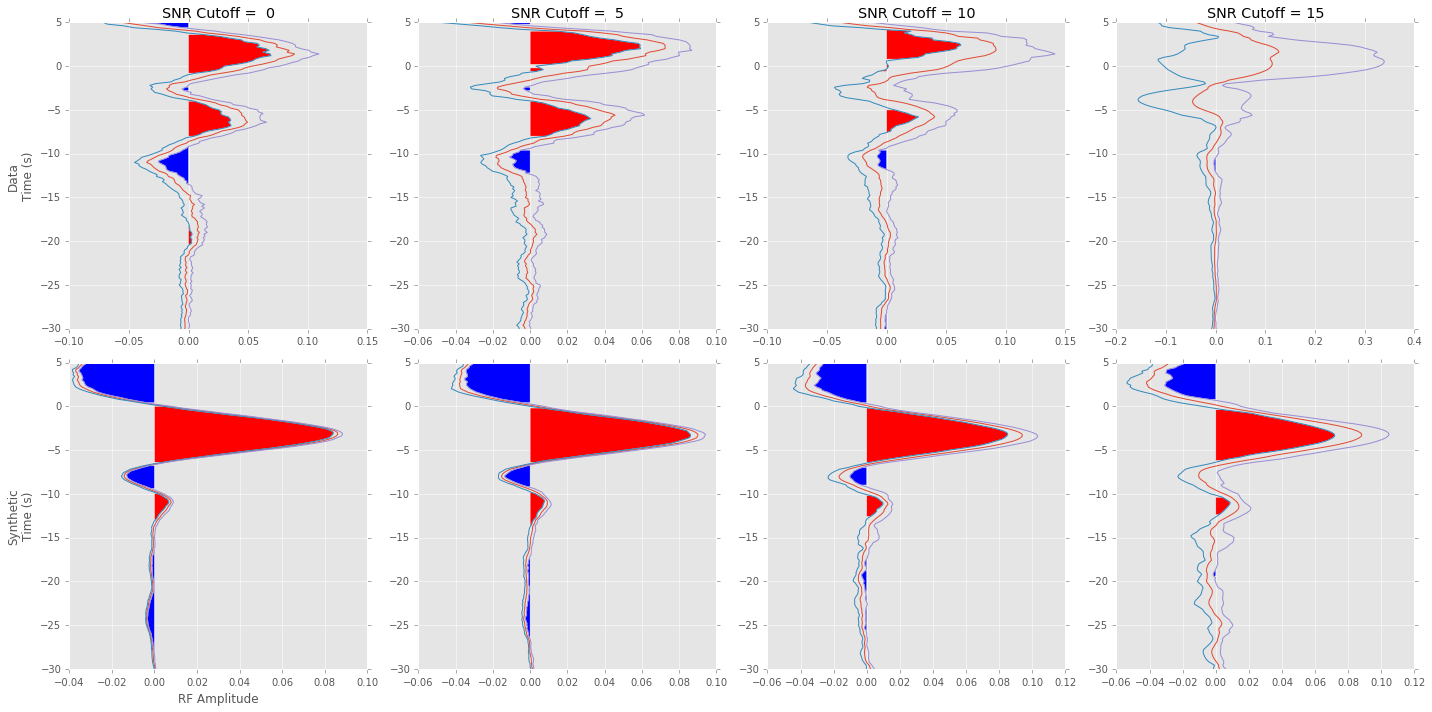

In [6]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(0, 20, 5)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('RSSD_SNR.eps')

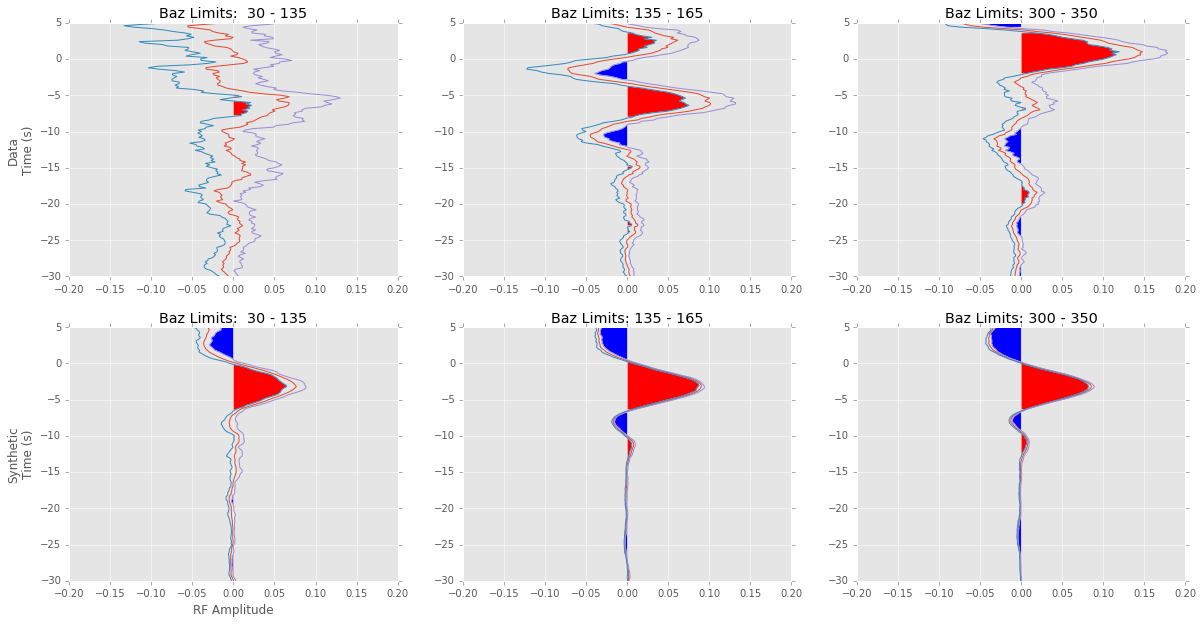

In [7]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

plt.figure(1,figsize=(20,10))

times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(baz)
    
plt.hist(tmp)

depthranges = [(30,135),(135,165),(300,350)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

       
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        plt.xlim(-0.2,0.2)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('RSSD_baz_limted.eps')